### Import dependencies and set seed

In [19]:
import torch
import torch.nn as nn 
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import numpy as np
import os
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

args = {
    "train_batch_size": 32,
    "valid_batch_size": 32,
    "seed": 42,
    "learning_rate": 1e-4,
    "num_epoch": 200,
    "warmup_epoch": 20,
    "momentum":0.9,
    "valid_epoch": 20,
    "model_save_path": "./model_save/model.pth",
    "num_sample": 6,
    "varified_scale": 1e-3
}

random_seed = args["seed"]
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(random_seed)

### load cifar10 dataset

In [20]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 标准化图像数据
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform) # 50000 images
trainloader = torch.utils.data.DataLoader(trainset, batch_size=args["train_batch_size"], shuffle=True, num_workers=0) # img, labels (4,3,32,32,)

validset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform) # 10000 images
validloader = torch.utils.data.DataLoader(validset, batch_size=args["valid_batch_size"], shuffle=False, num_workers=0)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


visualize the dataset

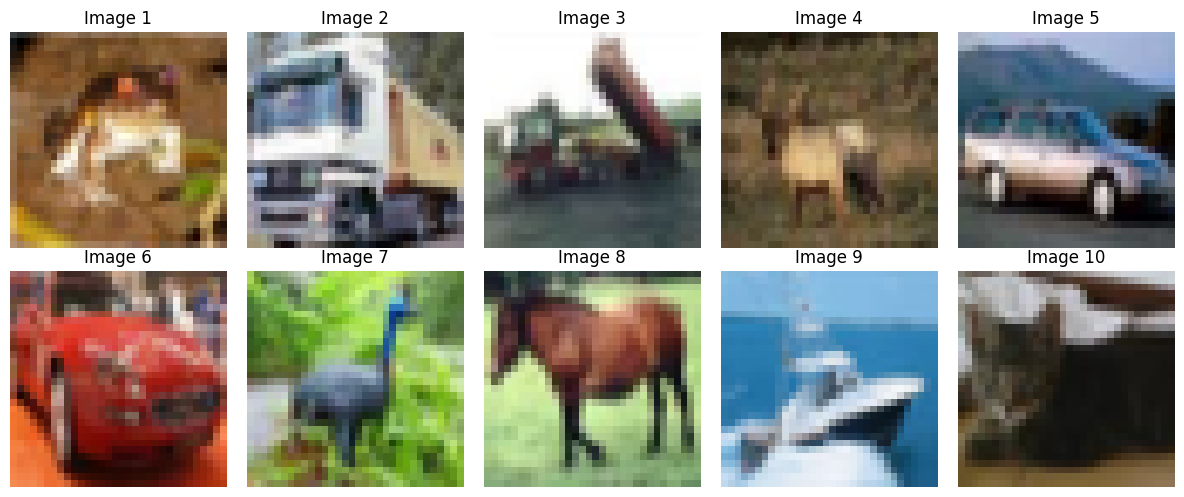

In [21]:
selected_images = [trainset[i][0] for i in range(10)]
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    image = selected_images[i].numpy() / 2 + 0.5
    image = np.transpose(image, (1, 2, 0))
    ax.imshow(image)
    ax.set_title(f"Image {i+1}")
    ax.axis('off')

plt.tight_layout()
plt.show()

### create model and training

In [23]:
from vae import VAE
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, LambdaLR
import math
device = torch.device("cuda")
model = VAE()
optimizer = optim.Adam(model.parameters(), lr=args["learning_rate"])

def lr_lambda(epoch):
    if epoch < args["warmup_epoch"]:
        # 热身阶段，学习率线性增加
        return (epoch + 1) / args["warmup_epoch"]
    else:
        # Cosine退火阶段
        return 0.5 * (1 + math.cos((epoch - args["warmup_epoch"]) / (args["num_epoch"] - args["warmup_epoch"]) * math.pi))

scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)

model = model.to(device)
train_loss = []
train_cn_loss = []
train_kl_loss = []
valid_loss = []
valid_cn_loss = []
valid_kl_loss = []

best_loss = 1000
valid_idx = []

for epoch in range(args["num_epoch"]):
    model.train()
    loss_mean = 0
    cn_loss_mean = 0
    kl_loss_mean = 0
    for batch in tqdm(trainloader):
        img, _ = batch
        img = img.to(device)
        _, loss_dict = model(img)
        loss = loss_dict["loss"]
        cn_loss = loss_dict["recon_loss"]
        kl_loss = loss_dict["kl_loss"]
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step(epoch + i / len(trainloader))
        loss_mean += loss.item()
        cn_loss_mean += cn_loss.item()
        kl_loss_mean += kl_loss.item()
    train_loss.append(loss_mean / len(trainloader))
    train_cn_loss.append(cn_loss_mean / len(trainloader))
    train_kl_loss.append(kl_loss_mean / len(trainloader))

    # validation
    if (epoch+1) % args["valid_epoch"] == 0:
        valid_idx.append(epoch)
        with torch.no_grad():
            model.eval()
            loss_mean = 0
            cn_loss_mean = 0
            kl_loss_mean = 0
            for batch in tqdm(validloader):
                img, _ = batch
                img = img.to(device)
                _, loss_dict = model(img)
                loss = loss_dict["loss"]
                cn_loss = loss_dict["recon_loss"]
                kl_loss = loss_dict["kl_loss"]
                loss_mean += loss.item()
                cn_loss_mean += cn_loss.item()
                kl_loss_mean += kl_loss.item()
        valid_loss.append(loss_mean / len(trainloader))
        valid_cn_loss.append(cn_loss_mean / len(trainloader))
        valid_kl_loss.append(kl_loss_mean / len(trainloader))
        if loss_mean / len(trainloader) < best_loss:
            best_loss = loss_mean / len(trainloader)
            save_dict = {
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'epoch': epoch,
            }
            torch.save(save_dict, args["model_save_path"])

plotting loss curve 

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
for i, ax in enumerate(axes.flat):
    if i == 0: # plot training
        ax.plot(train_loss, label="Loss")
        ax.plot(train_cn_loss, label="cn_Loss")
        ax.plot(train_kl_loss, label="kl_Loss")
        ax.legend()
        ax.set_title("Training")
    elif i == 1: # plot validating
        ax.plot(valid_loss, label="Loss")
        ax.plot(valid_cn_loss, label="cn_Loss")
        ax.plot(valid_kl_loss, label="kl_Loss")
        ax.legend()
        ax.set_title("Validating")
plt.tight_layout()
plt.show()

### Generating Samples

1. sampling from $ N(0, I)$

In [ ]:
del model
model = VAE()
model.load_state_dict(torch.load(args["model_save_path"])["model_state_dict"])
model = model.to(device)
model.eval()
with torch.no_grad():
    imgs = model.sample(args["num_sample"]).cpu()
fig, axes = plt.subplots(2, math.ceil(args["num_sample"] /2), figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    image = imgs[i].numpy() / 2 + 0.5
    image = np.transpose(image, (1, 2, 0))
    ax.imshow(image)
    ax.set_title(f"New Image {i+1}")
    ax.axis('off')
plt.tight_layout()
plt.show()

2. varifying existing images

In [ ]:
original_imgs = []
varified_imgs = []
with torch.no_grad():
    for i, batch in tqdm(validloader):
        if i == args["num_sample"]:
            break
        img, _ = batch
        original_imgs.append(img[0])
        img = img.to(device)
        recon = model.varify(img, scale=args["varified_scale"])
        varified_imgs.append(recon[0].cpu())
fig, axes = plt.subplots(2, args["num_sample"], figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    if i < args["num_sample"]:
        image = original_imgs[i].numpy() / 2 + 0.5
    else:
        image = varified_imgs[i - args["num_sample"]].numpy() / 2 + 0.5
    image = np.transpose(image, (1, 2, 0))
    ax.imshow(image)
    ax.set_title(f"New Image {i+1}")
    ax.axis('off')
plt.tight_layout()
plt.show()